#import libraries

In [3]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import time
import copy
from glob import glob
import imageio

#Download Intel Image Dataset using Kaggle api

In [14]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [17]:
!kaggle datasets download -d puneet6060/intel-image-classification

100% 346M/346M [00:16<00:00, 20.9MB/s]
100% 346M/346M [00:16<00:00, 22.1MB/s]


#Data directory set

In [18]:
!unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [19]:

train = '/content/seg_train/seg_train'
test = '/content/seg_test/seg_test'

#Data Augmentation

In [20]:
# Note: normalize mean and std are standardized for ImageNet

data_transforms = {
    train: transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    test: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#Load data

In [21]:

image_datasets = {x: datasets.ImageFolder(os.path.join(x), data_transforms[x]) for x in [train, test]}

dataloader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in [train, test]}

dataset_sizes = {x: len(image_datasets[x]) for  x in [train,test]}

class_names = image_datasets[train].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
resnet = models.resnet152(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

#Plot intel image dataset

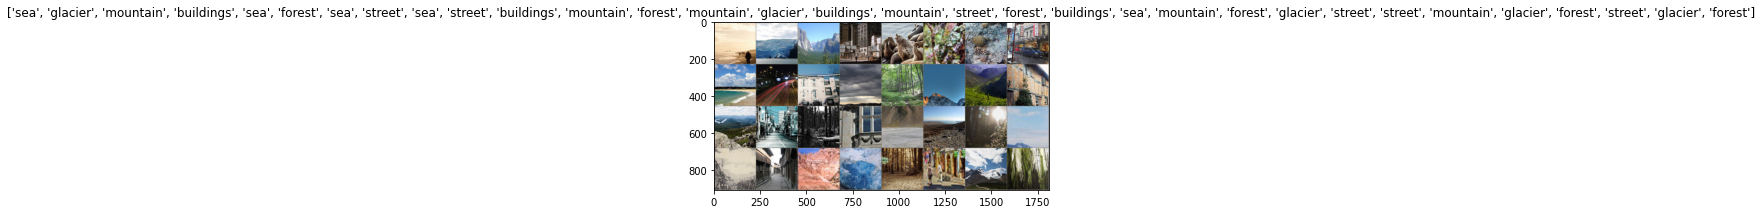

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloader[train]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
print(image_datasets[train])

Dataset ImageFolder
    Number of datapoints: 14034
    Root location: /content/seg_train/seg_train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


#Freeze CNN part of ResNet152 Model

In [14]:
for param in resnet.parameters():
    param.requires_grad = False

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Set fully connected sequential

In [17]:
resnet.fc = nn.Sequential(nn.Linear(2048, 1024),
                          nn.ReLU(),
                          nn.Dropout(0.25),
                          nn.Linear(1024, 256),
                          nn.ReLU(),
                          nn.Dropout(0.25),
                          nn.Linear(256, 6),
                          nn.LogSoftmax(dim=1))

resnet = resnet.to(device)


#Loss function/ Optimizer

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#Train Model Function

In [19]:
from datetime import datetime

In [20]:
def train_model(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for it in range(epochs):
        if it == 10 :
          for param in model.parameters():
           param.requires_grad = True
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in dataloader[train]:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
         
        train_loss = np.mean(train_loss)
        
        test_loss = []
        for inputs, targets in dataloader[test]:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        
        test_loss = np.mean(test_loss)
        
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        dt = datetime.now() - t0
        
        print(f'Epoch {it+1}/{epochs}, Train_Loss: {train_loss:.4f}, \Test_Loss: {test_loss:.4f}, Duration: {dt} ')
        
    return train_losses, test_losses

In [21]:
train_losses, test_losses = train_model(
                            resnet,
                            criterion,
                            optimizer,
                            dataloader[train],
                            dataloader[test],
                            epochs=40)

Epoch 1/40, Train_Loss: 0.6348, \Test_Loss: 0.3671, Duration: 0:02:18.012346 
Epoch 2/40, Train_Loss: 0.4187, \Test_Loss: 0.3239, Duration: 0:02:12.348367 
Epoch 3/40, Train_Loss: 0.4116, \Test_Loss: 0.3183, Duration: 0:02:12.303492 
Epoch 4/40, Train_Loss: 0.3940, \Test_Loss: 0.3011, Duration: 0:02:11.797530 
Epoch 5/40, Train_Loss: 0.3809, \Test_Loss: 0.2869, Duration: 0:02:12.182279 
Epoch 6/40, Train_Loss: 0.3760, \Test_Loss: 0.3113, Duration: 0:02:12.008638 
Epoch 7/40, Train_Loss: 0.3771, \Test_Loss: 0.2661, Duration: 0:02:12.230927 
Epoch 8/40, Train_Loss: 0.3743, \Test_Loss: 0.2872, Duration: 0:02:12.286634 
Epoch 9/40, Train_Loss: 0.3530, \Test_Loss: 0.2662, Duration: 0:02:13.266736 
Epoch 10/40, Train_Loss: 0.3539, \Test_Loss: 0.2692, Duration: 0:02:12.489712 
Epoch 11/40, Train_Loss: 0.4025, \Test_Loss: 0.2725, Duration: 0:06:02.206394 
Epoch 12/40, Train_Loss: 0.3366, \Test_Loss: 0.2625, Duration: 0:06:00.994119 
Epoch 13/40, Train_Loss: 0.3119, \Test_Loss: 0.2546, Duration

#Plot Train/Test loss

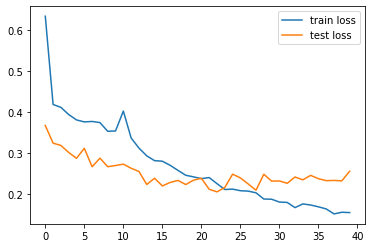

In [22]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

#Accuracy on Test data

In [24]:
from tqdm.autonotebook import tqdm

In [25]:
train_losses=[]
test_losses=[]
def accuracy(loader, model):
    num_corrects = 0
    num_samples = 0
    model.eval()
    loop = tqdm(loader)
    with torch.no_grad():
        for x, y in loop:
            x = x.to(device)
            y = y.to(device)
            scores = model(x)
            test_losses.append(scores.data)
            _, prediction = scores.max(1)
            num_corrects += (prediction == y).sum()
            num_samples += prediction.size(0)
            acc = (num_corrects/num_samples) * 100
            loop.set_postfix(acc=acc.item())
        print(f'Got {num_corrects}/{num_samples} with accuracy {acc:.4f}')

In [26]:
accuracy(dataloader[test], resnet)

  0%|          | 0/94 [00:00<?, ?it/s]

Got 2793/3000 with accuracy 93.1000


#Train dataset with Wide Residual Networks (WRNs)

In [5]:
wrn = models.wide_resnet101_2(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet101_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet101_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet101_2-32ee1156.pth


  0%|          | 0.00/243M [00:00<?, ?B/s]

In [ ]:
for param in wrn.parameters():
    param.requires_grad = False

In [ ]:
wrn.fc = nn.Sequential(nn.Linear(2048, 1024),
                          nn.ReLU(),
                          nn.Dropout(0.5),
                          nn.Linear(1024, 6),
                          nn.LogSoftmax(dim=1))

wrn = wrn.to(device)

In [ ]:
data_transforms = {
    train: transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    test: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(x), data_transforms[x]) for x in [train, test]}

dataloader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in [train, test]}

dataset_sizes = {x: len(image_datasets[x]) for  x in [train,test]}

class_names = image_datasets[train].classes

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(wrn.parameters(), lr=1e-3, betas=(0.9, 0.9))

In [ ]:
import torchsummary as summary

In [ ]:
def train_model(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for it in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in dataloader[train]:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
         
        train_loss = np.mean(train_loss)
        
        test_loss = []
        for inputs, targets in dataloader[test]:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        
        test_loss = np.mean(test_loss)
        
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        dt = datetime.now() - t0
        
        print(f'Epoch {it+1}/{epochs}, Train_Loss: {train_loss:.4f}, \Test_Loss: {test_loss:.4f}, Duration: {dt} ')
        
    return train_losses, test_losses

In [ ]:
train_losses, test_losses = train_model(
                            wrn,
                            criterion,
                            optimizer,
                            dataloader[train],
                            dataloader[test],
                            epochs=30)

Epoch 1/30, Train_Loss: 0.5889, \Test_Loss: 0.4229, Duration: 0:02:47.483557 
Epoch 2/30, Train_Loss: 0.5284, \Test_Loss: 0.3889, Duration: 0:02:53.000433 
Epoch 3/30, Train_Loss: 0.5128, \Test_Loss: 0.4088, Duration: 0:02:55.257686 
Epoch 4/30, Train_Loss: 0.5026, \Test_Loss: 0.3822, Duration: 0:02:56.183388 
Epoch 5/30, Train_Loss: 0.4924, \Test_Loss: 0.3778, Duration: 0:02:55.113532 
Epoch 6/30, Train_Loss: 0.4870, \Test_Loss: 0.3805, Duration: 0:02:54.972858 
Epoch 7/30, Train_Loss: 0.4976, \Test_Loss: 0.3897, Duration: 0:02:55.538814 
Epoch 8/30, Train_Loss: 0.4827, \Test_Loss: 0.3687, Duration: 0:02:55.844843 
Epoch 9/30, Train_Loss: 0.4908, \Test_Loss: 0.3762, Duration: 0:02:56.095436 
Epoch 10/30, Train_Loss: 0.5021, \Test_Loss: 0.3859, Duration: 0:02:55.548505 
Epoch 11/30, Train_Loss: 0.4970, \Test_Loss: 0.3798, Duration: 0:02:55.285072 
Epoch 12/30, Train_Loss: 0.4954, \Test_Loss: 0.3874, Duration: 0:02:55.819190 
Epoch 13/30, Train_Loss: 0.4992, \Test_Loss: 0.3777, Duration

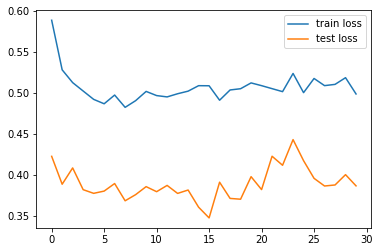

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
n_correct = 0
n_total = 0
for inputs, targets in dataloader[train]:
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = wrn(inputs)
  _, predictions = torch.max(outputs, -1)
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]
train_acc = n_correct/n_total

n_correct = 0
n_total = 0
for inputs, targets in dataloader[test]:
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = wrn(inputs)
  _, predictions = torch.max(outputs, -1)
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]
test_acc = n_correct/n_total
print(f'Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train acc: 0.8312, Test acc: 0.8653


In [ ]:
train_losses=[]
test_losses=[]
def accuracy(loader, model):
    num_corrects = 0
    num_samples = 0
    model.eval()
    loop = tqdm(loader)
    with torch.no_grad():
        for x, y in loop:
            x = x.to(device)
            y = y.to(device)
            scores = model(x)
            test_losses.append(scores.data)
            _, prediction = scores.max(1)
            num_corrects += (prediction == y).sum()
            num_samples += prediction.size(0)
            acc = (num_corrects/num_samples) * 100
            loop.set_postfix(acc=acc.item())
        print(f'Got {num_corrects}/{num_samples} with accuracy {acc:.4f}')

In [ ]:
accuracy(dataloader[test], wrn)

  0%|          | 0/94 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Got 2685/3000 with accuracy 89.5000


#Train intel-image using Inception-ResNet

In [7]:
model = models.inception_v3(pretrained=True)



In [ ]:
def get_model():
    model = models.inception_v3(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False #Freezing all the layers and changing only the below layers
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
                            nn.Linear(2048,1024),
                            nn.ReLU(),
                            nn.Dropout(0.3),
                            nn.Linear(1024,256),
                            nn.ReLU(),
                            nn.Dropout(0.3),
                            nn.Linear(256,6),
                            nn.LogSoftmax(dim=1))
    model.aux_logits = False
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.9))
    return model.to(device), loss_fn, optimizer

In [ ]:
!pip install torchsummary


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:


from torchsummary import summary

input_shape = (3,300,300)
summary(model.to(device), input_shape)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [ ]:
data_transforms = {
    train: transforms.Compose([
        transforms.Resize((300,300)),
        transforms.RandomRotation(degrees=(0, 180)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    test: transforms.Compose([
        transforms.Resize((300,300)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(x), data_transforms[x]) for x in [train, test]}

dataloader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in [train, test]}

dataset_sizes = {x: len(image_datasets[x]) for  x in [train,test]}

class_names = image_datasets[train].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def train_batch(x, y, model, opt, loss_fn):
    output = model(x)
#     print(f"type of output - {type(output)}")
    batch_loss = loss_fn(output, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [ ]:
model, loss_fn, optimizer = get_model()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(1,31):
    d0 = datetime.now()
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(dataloader[train])):
#         print(f"ix - {ix}, {batch}")
        x, y = batch
#         print(f"type of x - {type(x)}, type of y - {type(y)}")
        x, y= x.to(device), y.to(device)
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()
    train_epoch_accuracy = np.mean(train_epoch_accuracies)        
    print('Epoch:',epoch,'Train Loss:',train_epoch_loss,'Train Accuracy:',train_epoch_accuracy)

    for ix, batch in enumerate(iter(dataloader[test])):
        x, y = batch
        x, y= x.to(device), y.to(device)
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)    
        val_epoch_accuracy = np.mean(val_is_correct)
    dt = datetime.now() - d0
    print('Epoch:',epoch,'Validation Loss:',validation_loss,'Validation Accuracy:',val_epoch_accuracy, 'Duration:',dt)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

1
Epoch: 1 Train Loss: 0.6147843960816877 Train Accuracy: 0.7997719823286304
Epoch: 1 Validation Loss: 0.2536163628101349 Validation Accuracy: 0.875 Duration: 0:02:07.855528
2
Epoch: 2 Train Loss: 0.4008501869263573 Train Accuracy: 0.8539261792788941
Epoch: 2 Validation Loss: 0.26119133830070496 Validation Accuracy: 0.9166666666666666 Duration: 0:02:06.838021
3
Epoch: 3 Train Loss: 0.3703767183260114 Train Accuracy: 0.8687473279179136
Epoch: 3 Validation Loss: 0.27270570397377014 Validation Accuracy: 0.7916666666666666 Duration: 0:02:06.468786
4
Epoch: 4 Train Loss: 0.35774958668306367 Train Accuracy: 0.8714550377654268
Epoch: 4 Validation Loss: 0.1237589493393898 Validation Accuracy: 0.9583333333333334 Duration: 0:02:06.567287
5
Epoch: 5 Train Loss: 0.3400826733856375 Train Accuracy: 0.8782955679065128
Epoch: 5 Validation Loss: 0.4670526683330536 Validation Accuracy: 0.875 Duration: 0:02:06.556704
6
Epoch: 6 Train Loss: 0.33567620564362455 Train Accuracy: 0.8784380789511187
Epoch: 6 V

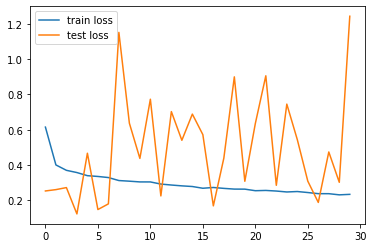

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='test loss')
plt.legend()
plt.show()

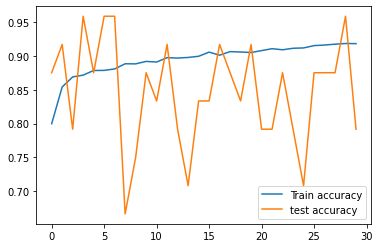

In [ ]:
plt.plot(train_accuracies, label='Train accuracy')
plt.plot(val_accuracies, label='test accuracy')
plt.legend()
plt.show()

In [ ]:
n_correct = 0
n_total = 0
for inputs, targets in dataloader[train]:
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = model(inputs)
  _, predictions = torch.max(outputs, -1)
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]
train_acc = n_correct/n_total

n_correct = 0
n_total = 0
for inputs, targets in dataloader[test]:
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = model(inputs)
  _, predictions = torch.max(outputs, -1)
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]
test_acc = n_correct/n_total
print(f'Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')

Train acc: 0.9111, Test acc: 0.8193


In [ ]:
train_losses=[]
test_losses=[]
def accuracy(loader, model):
    num_corrects = 0
    num_samples = 0
    model.eval()
    loop = tqdm(loader)
    with torch.no_grad():
        for x, y in loop:
            x = x.to(device)
            y = y.to(device)
            scores = model(x)
            test_losses.append(scores.data)
            _, prediction = scores.max(1)
            num_corrects += (prediction == y).sum()
            num_samples += prediction.size(0)
            acc = (num_corrects/num_samples) * 100
            loop.set_postfix(acc=acc.item())
        print(f'Got {num_corrects}/{num_samples} with accuracy {acc:.4f}')

In [ ]:
accuracy(dataloader[test], model)

  0%|          | 0/94 [00:00<?, ?it/s]

Got 2609/3000 with accuracy 86.9667


#Models summary

In [10]:
from torchsummary import summary

input_shape = (3,300,300)
summary(resnet.to(device), input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           9,408
       BatchNorm2d-2         [-1, 64, 150, 150]             128
              ReLU-3         [-1, 64, 150, 150]               0
         MaxPool2d-4           [-1, 64, 75, 75]               0
            Conv2d-5           [-1, 64, 75, 75]           4,096
       BatchNorm2d-6           [-1, 64, 75, 75]             128
              ReLU-7           [-1, 64, 75, 75]               0
            Conv2d-8           [-1, 64, 75, 75]          36,864
       BatchNorm2d-9           [-1, 64, 75, 75]             128
             ReLU-10           [-1, 64, 75, 75]               0
           Conv2d-11          [-1, 256, 75, 75]          16,384
      BatchNorm2d-12          [-1, 256, 75, 75]             512
           Conv2d-13          [-1, 256, 75, 75]          16,384
      BatchNorm2d-14          [-1, 256,

In [11]:
from torchsummary import summary

input_shape = (3,300,300)
summary(wrn.to(device), input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           9,408
       BatchNorm2d-2         [-1, 64, 150, 150]             128
              ReLU-3         [-1, 64, 150, 150]               0
         MaxPool2d-4           [-1, 64, 75, 75]               0
            Conv2d-5          [-1, 128, 75, 75]           8,192
       BatchNorm2d-6          [-1, 128, 75, 75]             256
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]         147,456
       BatchNorm2d-9          [-1, 128, 75, 75]             256
             ReLU-10          [-1, 128, 75, 75]               0
           Conv2d-11          [-1, 256, 75, 75]          32,768
      BatchNorm2d-12          [-1, 256, 75, 75]             512
           Conv2d-13          [-1, 256, 75, 75]          16,384
      BatchNorm2d-14          [-1, 256,

In [12]:
from torchsummary import summary

input_shape = (3,300,300)
summary(model.to(device), input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,